I trained the model on Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/EPFL/Image Analysis and Pattern Recognition/iapr-2020/project/operators.zip' '.'

In [ ]:
!unzip -q operators.zip -d '.'

In [ ]:
!rm -rf __MACOSX

In [5]:
import datetime
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [6]:
data_dir = pathlib.Path('operators')
plus_path = list(data_dir.glob('plus/*.png'))
minus_path = list(data_dir.glob('minus/*.png'))
multiply_path = list(data_dir.glob('multiply/*.png'))
divide_path = list(data_dir.glob('divide/*.png'))
equal_path = list(data_dir.glob('equal/*.png'))

plus = [Image.open(path) for path in plus_path]
minus = [Image.open(path) for path in minus_path]
multiply = [Image.open(path) for path in multiply_path]
divide = [Image.open(path) for path in divide_path]
equal = [Image.open(path) for path in equal_path]

plus_numpy = np.array([np.array(img) for img in plus])
minus_numpy = np.array([np.array(img) for img in minus])
multiply_numpy = np.array([np.array(img) for img in multiply])
divide_numpy = np.array([np.array(img) for img in divide])
equal_numpy = np.array([np.array(img) for img in equal])

x_op = np.concatenate((plus_numpy, minus_numpy, multiply_numpy, divide_numpy, equal_numpy))
y_op = np.concatenate((9 * np.ones(len(plus)), 10 * np.ones(len(minus)), 11 * np.ones(len(multiply)), 12 * np.ones(len(divide)), 13 * np.ones(len(equal))))
print(x_op.shape)
print(y_op.shape)

rand_perm = np.random.permutation(len(y_op))
x_op = x_op[rand_perm]
y_op = y_op[rand_perm]

x_op_train = x_op[:27000]
x_op_test = x_op[27000:]
y_op_train = y_op[:27000]
y_op_test = y_op[27000:]

(31665, 28, 28)
(31665,)


In [7]:
now = datetime.datetime.now

num_classes = 14

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
print(input_shape)

(28, 28, 1)


In [ ]:
def train_model(model, train, test, num_classes, epochs, batch_size, steps):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    t = now()

    datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range = [0.9, 1.6],
        width_shift_range=0.1,
        height_shift_range=0.1)


    #datagen.fit(X_train)
    train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
    test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

    history = model.fit_generator(train_gen, 
                                  epochs=epochs, 
                                  steps_per_epoch=steps,
                                  validation_data=test_gen,
                                  validation_steps=steps
    )

    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [9]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [10]:
x_train = x_train[np.where(y_train != 9)[0]]
y_train = y_train[np.where(y_train != 9)[0]]
x_test = x_test[np.where(y_test != 9)[0]]
y_test = y_test[np.where(y_test != 9)[0]]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(54051, 28, 28)
(54051,)
(8991, 28, 28)
(8991,)


In [11]:
x_train = np.concatenate((x_train, x_op_train))
y_train = np.concatenate((y_train, y_op_train))
x_test = np.concatenate((x_test, x_op_test))
y_test = np.concatenate((y_test, y_op_test))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(81051, 28, 28)
(81051,)
(13656, 28, 28)
(13656,)


In [ ]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(16, 3, padding='same', input_shape=input_shape),
    Activation('relu'),
    Conv2D(16, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    Conv2D(32, 3, padding='same'),
    Activation('relu'),
    Conv2D(32, 3, padding='same'),
    Activation('relu'),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(256),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

In [ ]:
# create complete model
model = Sequential(feature_layers + classification_layers)

# train model
train_model(model,
            (x_train, y_train),
            (x_test, y_test), num_classes, 30, 256)

x_train shape: (81051, 28, 28, 1)
81051 train samples
13656 test samples
Epoch 1/30
316/316 [==============================] - 27s 84ms/step - loss: 1.1806 - accuracy: 0.5997 - val_loss: 0.5366 - val_accuracy: 0.8226
Epoch 2/30
316/316 [==============================] - 21s 67ms/step - loss: 0.5151 - accuracy: 0.8289 - val_loss: 0.2075 - val_accuracy: 0.9070
Epoch 3/30
316/316 [==============================] - 21s 67ms/step - loss: 0.3764 - accuracy: 0.8752 - val_loss: 0.2494 - val_accuracy: 0.9190
Epoch 4/30
316/316 [==============================] - 21s 67ms/step - loss: 0.3168 - accuracy: 0.8958 - val_loss: 0.1921 - val_accuracy: 0.9379
Epoch 5/30
316/316 [==============================] - 22s 69ms/step - loss: 0.2770 - accuracy: 0.9086 - val_loss: 0.2276 - val_accuracy: 0.9441
Epoch 6/30
316/316 [==============================] - 22s 69ms/step - loss: 0.2574 - accuracy: 0.9145 - val_loss: 0.1643 - val_accuracy: 0.9501
Epoch 7/30
316/316 [==============================] - 22s 69ms/

In [ ]:
train_model(model,
            (x_train, y_train),
            (x_test, y_test), num_classes, 10, 256)

x_train shape: (81051, 28, 28, 1)
81051 train samples
13656 test samples
Epoch 1/10
500/500 [==============================] - 55s 110ms/step - loss: 0.1307 - accuracy: 0.9575 - val_loss: 0.0575 - val_accuracy: 0.9732
Epoch 2/10
500/500 [==============================] - 55s 109ms/step - loss: 0.1266 - accuracy: 0.9588 - val_loss: 0.0579 - val_accuracy: 0.9744
Epoch 3/10
500/500 [==============================] - 54s 107ms/step - loss: 0.1242 - accuracy: 0.9592 - val_loss: 0.0855 - val_accuracy: 0.9739
Epoch 4/10
500/500 [==============================] - 53s 106ms/step - loss: 0.1222 - accuracy: 0.9610 - val_loss: 0.0574 - val_accuracy: 0.9734
Epoch 5/10
500/500 [==============================] - 52s 105ms/step - loss: 0.1201 - accuracy: 0.9610 - val_loss: 0.0617 - val_accuracy: 0.9745
Epoch 6/10
500/500 [==============================] - 52s 104ms/step - loss: 0.1178 - accuracy: 0.9624 - val_loss: 0.0366 - val_accuracy: 0.9749
Epoch 7/10
500/500 [==============================] - 52s

In [ ]:
!cp '/content/drive/My Drive/EPFL/Image Analysis and Pattern Recognition/iapr-2020/project/data.zip' '.'

In [ ]:
!unzip -q data.zip -d '.'

In [ ]:
!rm -rf __MACOSX

In [16]:
data_dir = pathlib.Path('data')
two_path = list(data_dir.glob('2/*.png'))
three_path = list(data_dir.glob('3/*.png'))
seven_path = list(data_dir.glob('7/*.png'))
plus_path = list(data_dir.glob('plus/*.png'))
multiply_path = list(data_dir.glob('multiply/*.png'))
divide_path = list(data_dir.glob('divide/*.png'))
equal_path = list(data_dir.glob('equal/*.png'))

two = [Image.open(path) for path in two_path]
three = [Image.open(path) for path in three_path]
seven = [Image.open(path) for path in seven_path]
plus = [Image.open(path) for path in plus_path]
multiply = [Image.open(path) for path in multiply_path]
divide = [Image.open(path) for path in divide_path]
equal = [Image.open(path) for path in equal_path]

two_numpy = np.array([np.array(img) for img in two])
three_numpy = np.array([np.array(img) for img in three])
seven_numpy = np.array([np.array(img) for img in seven])
plus_numpy = np.array([np.array(img) for img in plus])
multiply_numpy = np.array([np.array(img) for img in multiply])
divide_numpy = np.array([np.array(img) for img in divide])
equal_numpy = np.array([np.array(img) for img in equal])

x_vid = np.concatenate((two_numpy, three_numpy, seven_numpy, plus_numpy, multiply_numpy, divide_numpy, equal_numpy))
y_vid = np.concatenate((2 * np.ones(len(two)), 3 * np.ones(len(three)), 7 * np.ones(len(seven)), 9 * np.ones(len(plus)), 11 * np.ones(len(multiply)), 12 * np.ones(len(divide)), 13 * np.ones(len(equal))))
print(x_vid.shape)
print(y_vid.shape)

rand_perm = np.random.permutation(len(y_vid))
x_vid = x_vid[rand_perm]
y_vid = y_vid[rand_perm]

(70, 28, 28)
(70,)


In [ ]:
x_vid_train = x_vid[:50]
x_vid_test = x_vid[50:]
y_vid_train = y_vid[:50]
y_vid_test = y_vid[50:]

In [ ]:
train_model(model,
            (x_vid_train, y_vid_train),
            (x_vid_test, y_vid_test), num_classes, 1, 16, 200)

x_train shape: (50, 28, 28, 1)
50 train samples
20 test samples
Epoch 1/1
200/200 [==============================] - 15s 77ms/step - loss: 0.0418 - accuracy: 0.9864 - val_loss: 4.2733e-05 - val_accuracy: 1.0000
Training time: 0:00:16.341880
Test score: 3.844453203782905e-06
Test accuracy: 1.0


In [ ]:
model.save('model.h5')

In [ ]:
!cp '/content/drive/My Drive/EPFL/Image Analysis and Pattern Recognition/iapr-2020/project/model.h5' '.'

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# load model
model = load_model('model.h5')

[[1.8525431e-16 9.9752146e-01 8.3179739e-09 1.3397172e-09 7.3287892e-10
  1.2381274e-11 4.3416385e-08 1.5857279e-07 7.8588608e-11 2.1331529e-14
  2.4782494e-03 4.7790562e-19 3.9642786e-17 1.8089593e-16]]
1


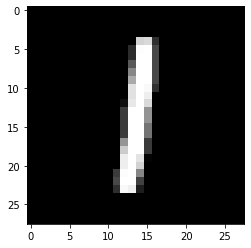

In [47]:
test_idx = np.random.choice(np.where(y_test == 1)[0])
prob = model.predict(x_test[test_idx].reshape(1, 28, 28, 1) / 255.)
pred = np.argmax(prob)

print(prob)
print(pred)
plt.imshow(x_test[test_idx], cmap='gray')
plt.show()